# LSTM

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

# 2. DATA VISUALIZATION
# ============================================================================

In [3]:
print("Downloading S&P 500 data...")
ticker = "^GSPC"  # S&P 500 ticker symbol
start_date = "2020-01-01"
end_date = "2024-12-31"

# Download data from Yahoo Finance
data = yf.download(ticker, start=start_date, end=end_date)
print(f"Data shape: {data.shape}")
print(f"Date range: {data.index[0]} to {data.index[-1]}")
print("\nFirst few rows:")
print(data.head())

# Use only the Close price
df = data[['Close']].copy()
df.columns = ['Close']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Data shape: (1257, 5)
Date range: 2020-01-02 00:00:00 to 2024-12-30 00:00:00

First few rows:
Price             Close         High          Low         Open      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2020-01-02  3257.850098  3258.139893  3235.530029  3244.669922  3459930000
2020-01-03  3234.850098  3246.149902  3222.340088  3226.360107  3484700000
2020-01-06  3246.280029  3246.840088  3214.639893  3217.550049  3702460000
2020-01-07  3237.179932  3244.909912  3232.429932  3241.860107  3435910000
2020-01-08  3253.050049  3267.070068  3236.669922  3238.590088  3726840000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1257 entries, 2020-01-02 to 2024-12-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1257 non-null   float64
dtypes: float64(1)
memory usage: 19.6 KB


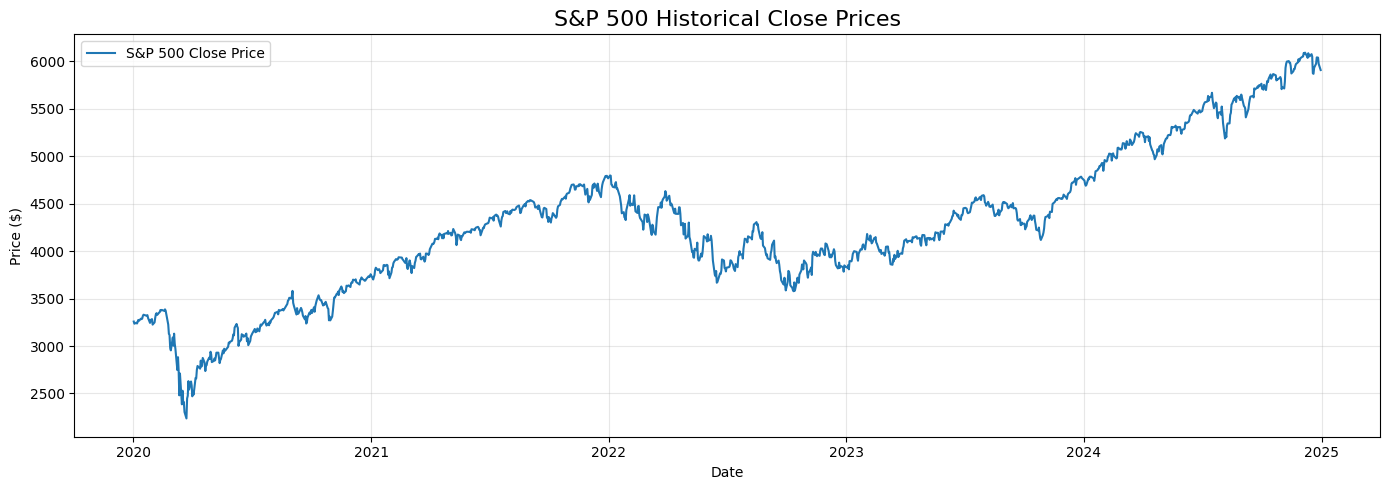

In [5]:
plt.figure(figsize=(14, 5))
plt.plot(df.index, df['Close'], label='S&P 500 Close Price')
plt.title('S&P 500 Historical Close Prices', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. DATA PREPROCESSING
# ============================================================================


In [6]:
# Split into train and test sets (80-20 split)
split_date = "2024-01-01"
train_data = df.loc[:split_date]
test_data  = df.loc[split_date:]


print(f"\nTraining set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")


Training set size: 1006
Test set size: 251


In [25]:
train_data

,Close
Date,
2020-01-02,3257.850098
2020-01-03,3234.850098
2020-01-06,3246.280029
2020-01-07,3237.179932
2020-01-08,3253.050049
...,...
2023-12-22,4754.629883
2023-12-26,4774.750000
2023-12-27,4781.580078


In [7]:
# Scale the data to [0, 1] range
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)


In [8]:
# Use 60 days of historical data to predict the next day
sequence_length = 60

X_train, y_train = create_sequences(train_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)

print(f"\nX_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")



X_train shape: (946, 60, 1)
y_train shape: (946, 1)
X_test shape: (191, 60, 1)
y_test shape: (191, 1)


# 4. BUILD LSTM MODEL
# ============================================================================


In [9]:
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    
    Dense(units=25),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

print("\nModel Summary:")
model.summary()


Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

# 5. TRAIN THE MODEL
# ============================================================================

In [10]:
print("\nTraining the model...")

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)


Training the model...
Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.0728 - val_loss: 0.0025
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0110 - val_loss: 0.0060
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0080 - val_loss: 0.0047
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0066 - val_loss: 0.0041
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0057 - val_loss: 0.0037
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0054 - val_loss: 0.0027
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0047 - val_loss: 0.0037
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0046 - val_loss: 0.0031
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0049 - val_loss: 0.0050
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0046 - val_loss: 0.0026
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1

# 6. EVALUATE THE MODEL
# ============================================================================

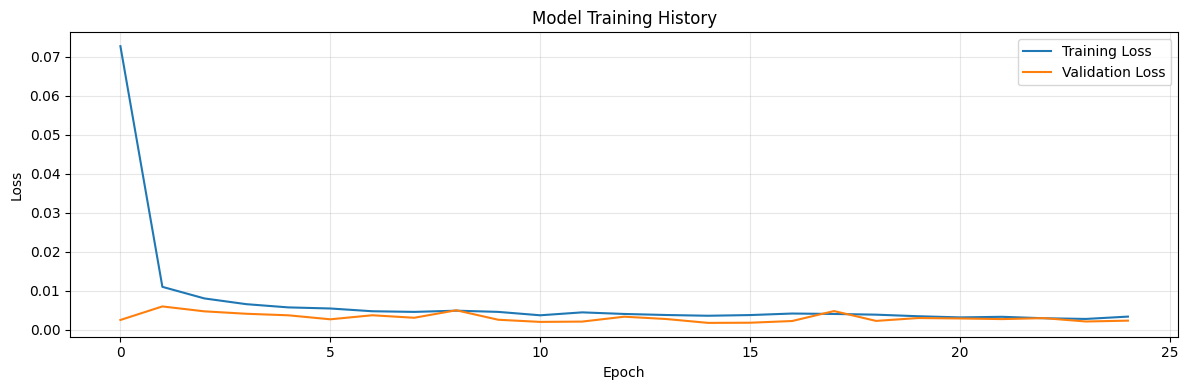

In [11]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [12]:
# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform to get actual prices
train_predictions = scaler.inverse_transform(train_predictions)
y_train_actual = scaler.inverse_transform(y_train)
test_predictions = scaler.inverse_transform(test_predictions)
y_test_actual = scaler.inverse_transform(y_test)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predictions))
train_mae = mean_absolute_error(y_train_actual, train_predictions)
test_mae = mean_absolute_error(y_test_actual, test_predictions)

print(f"\n{'='*50}")
print(f"MODEL PERFORMANCE")
print(f"{'='*50}")
print(f"Training RMSE: ${train_rmse:.2f}")
print(f"Test RMSE: ${test_rmse:.2f}")
print(f"Training MAE: ${train_mae:.2f}")
print(f"Test MAE: ${test_mae:.2f}")
print(f"{'='*50}")


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

MODEL PERFORMANCE
Training RMSE: $108.40
Test RMSE: $161.90
Training MAE: $81.12
Test MAE: $141.74


# 7. VISUALIZE PREDICTIONS
# ============================================================================

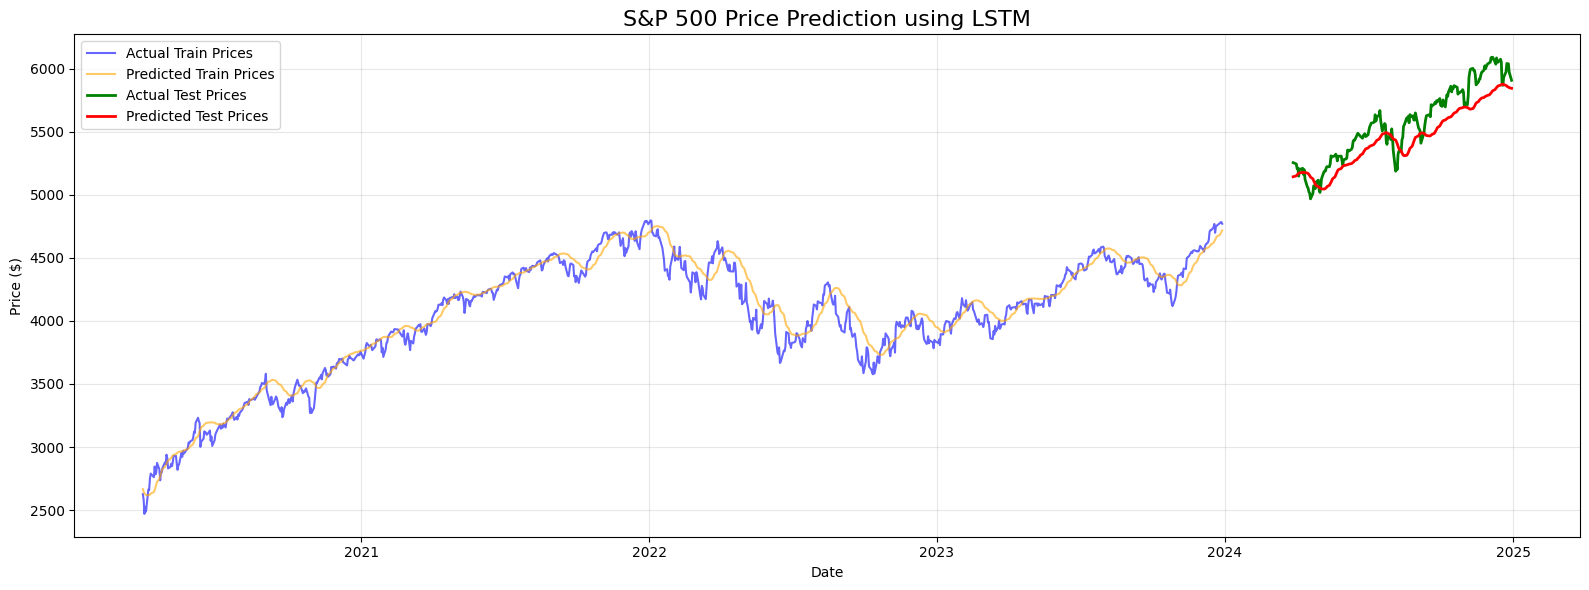

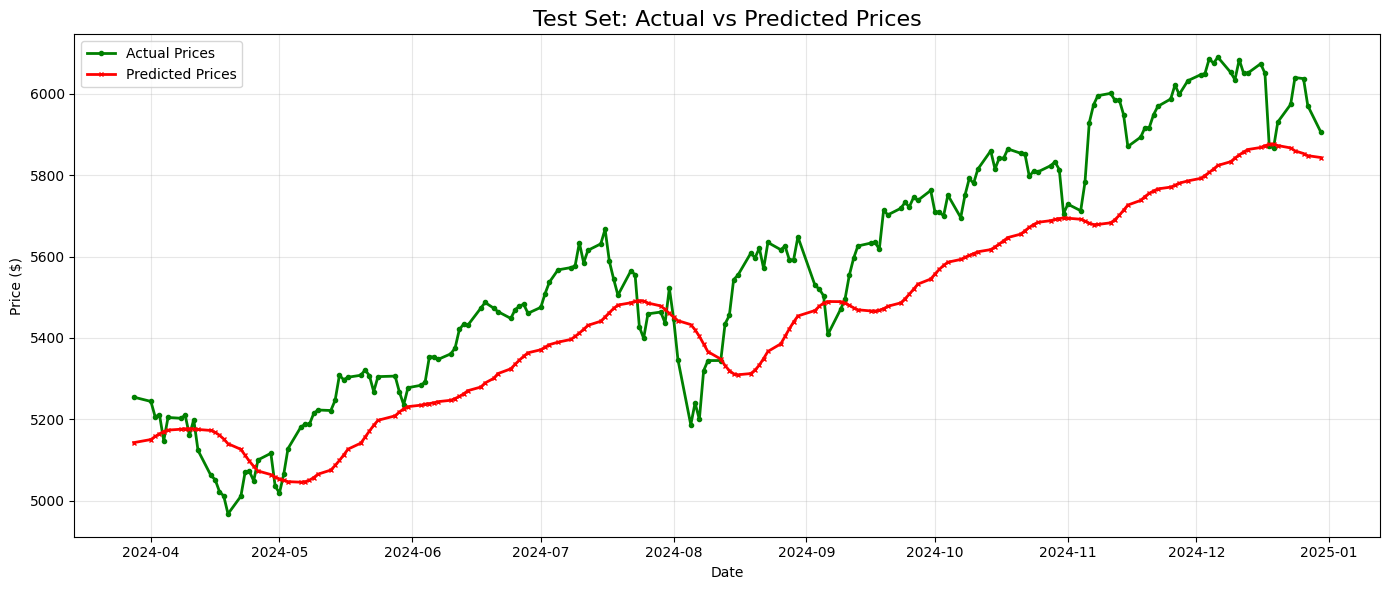

In [13]:
# Prepare data for plotting
train_dates_raw = train_data.index
test_dates_raw  = test_data.index

train_dates = train_dates_raw[sequence_length:]
test_dates  = test_dates_raw[sequence_length:]
plt.figure(figsize=(16, 6))

# Plot training data
plt.plot(train_dates, y_train_actual, label='Actual Train Prices', color='blue', alpha=0.6)
plt.plot(train_dates, train_predictions, label='Predicted Train Prices', color='orange', alpha=0.6)

# Plot test data
plt.plot(test_dates, y_test_actual, label='Actual Test Prices', color='green', linewidth=2)
plt.plot(test_dates, test_predictions, label='Predicted Test Prices', color='red', linewidth=2)

plt.title('S&P 500 Price Prediction using LSTM', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Zoom in on test predictions
plt.figure(figsize=(14, 6))
plt.plot(test_dates, y_test_actual, label='Actual Prices', color='green', linewidth=2, marker='o', markersize=3)
plt.plot(test_dates, test_predictions, label='Predicted Prices', color='red', linewidth=2, marker='x', markersize=3)
plt.title('Test Set: Actual vs Predicted Prices', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# 8. FORECAST FUTURE PRICES
# ============================================================================

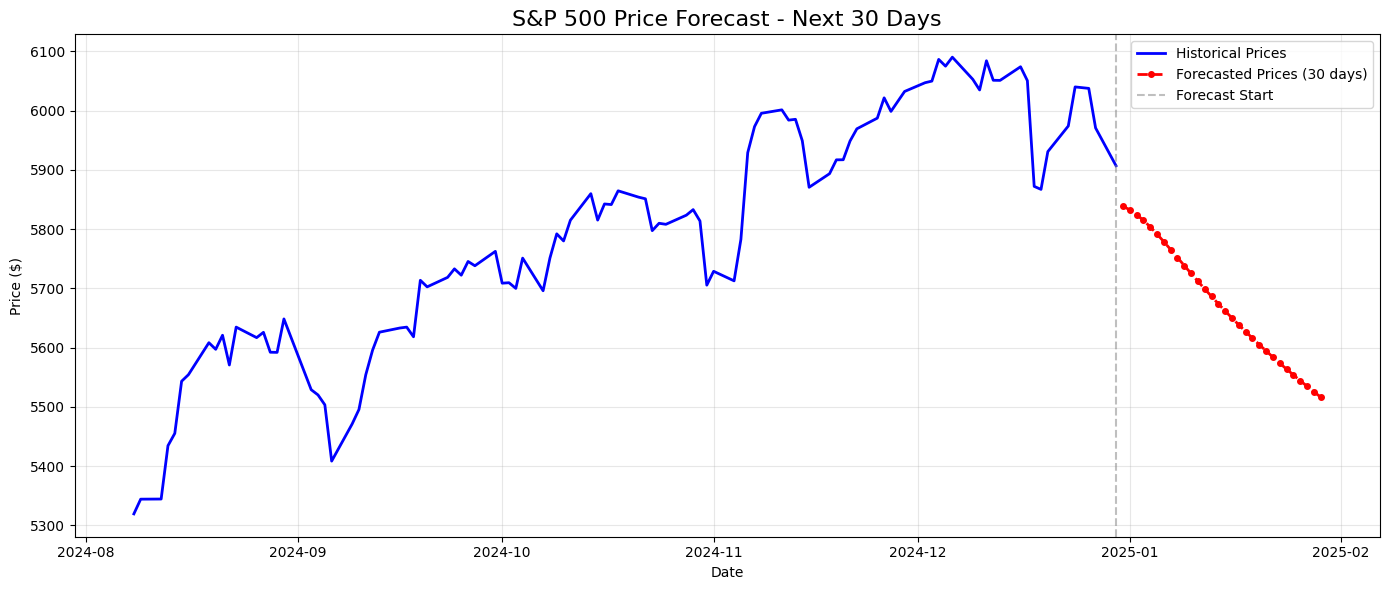


Future Predictions for next 30 days:
Date            Predicted Price     
-----------------------------------
2024-12-31      $5,838.81
2025-01-01      $5,832.62
2025-01-02      $5,824.66
2025-01-03      $5,815.00
2025-01-04      $5,803.92
2025-01-05      $5,791.78
2025-01-06      $5,778.90
2025-01-07      $5,765.59
2025-01-08      $5,752.10
2025-01-09      $5,738.59
2025-01-10      $5,725.19
2025-01-11      $5,711.99
2025-01-12      $5,699.03
2025-01-13      $5,686.35
2025-01-14      $5,673.94
2025-01-15      $5,661.81
2025-01-16      $5,649.95
2025-01-17      $5,638.35
2025-01-18      $5,627.01
2025-01-19      $5,615.91
2025-01-20      $5,605.05
2025-01-21      $5,594.40
2025-01-22      $5,583.98
2025-01-23      $5,573.75
2025-01-24      $5,563.73
2025-01-25      $5,553.90
2025-01-26      $5,544.27
2025-01-27      $5,534.81
2025-01-28      $5,525.53
2025-01-29      $5,516.43


In [14]:
def forecast_future(model, last_sequence, scaler, days=30):
    """Forecast future prices"""
    predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(days):
        # Predict next value
        pred = model.predict(current_sequence.reshape(1, sequence_length, 1), verbose=0)
        predictions.append(pred[0, 0])
        
        # Update sequence: remove first value and append prediction
        current_sequence = np.append(current_sequence[1:], pred[0, 0])
    
    # Inverse transform predictions
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions

# Get the last sequence from the data
last_sequence = test_scaled[-sequence_length:]

# Forecast next 30 days
forecast_days = 30
future_predictions = forecast_future(model, last_sequence, scaler, forecast_days)

# Create future dates
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_days, freq='D')

# Plot forecast
plt.figure(figsize=(14, 6))
plt.plot(df.index[-100:], df['Close'].values[-100:], label='Historical Prices', color='blue', linewidth=2)
plt.plot(future_dates, future_predictions, label=f'Forecasted Prices ({forecast_days} days)', 
         color='red', linewidth=2, linestyle='--', marker='o', markersize=4)
plt.axvline(x=last_date, color='gray', linestyle='--', alpha=0.5, label='Forecast Start')
plt.title(f'S&P 500 Price Forecast - Next {forecast_days} Days', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nFuture Predictions for next {forecast_days} days:")
print(f"{'Date':<15} {'Predicted Price':<20}")
print("-" * 35)
for date, price in zip(future_dates, future_predictions):
    print(f"{date.strftime('%Y-%m-%d'):<15} ${price[0]:,.2f}")


In [15]:
# 9. SAVE THE MODEL (OPTIONAL)
# ============================================================================

# Uncomment to save the model
# model.save('sp500_lstm_model.h5')
# print("\nModel saved as 'sp500_lstm_model.h5'")

# To load the model later:
# from tensorflow.keras.models import load_model
# loaded_model = load_model('sp500_lstm_model.h5')

In [23]:
lstm_results = pd.DataFrame({
    'Date': test_dates,
    'Actual': y_test_actual.flatten(),
    'Forecast': test_predictions.flatten(),
})
lstm_results['Error'] = lstm_results['Forecast'] - lstm_results['Actual']
lstm_results['Absolute_Error'] = np.abs(lstm_results['Error'])
lstm_results['APE'] = lstm_results['Absolute_Error'] / lstm_results['Actual'] * 100



In [24]:
std_error = lstm_results['Error'].rolling(window=30).std().fillna(method='bfill')

lstm_results['Lower_95'] = lstm_results['Forecast'] - 1.96 * std_error
lstm_results['Upper_95'] = lstm_results['Forecast'] + 1.96 * std_error
lstm_results.to_csv("lstm_predictions.csv", index=False)


In [28]:
train_data.to_csv("lstm_train.csv")